In [23]:
!pip install paddlepaddle==3.0.0 -i https://www.paddlepaddle.org.cn/packages/stable/cpu/
!pip install paddleocr==3.0.1
!pip install pandas
!pip show paddleocr

Looking in indexes: https://www.paddlepaddle.org.cn/packages/stable/cpu/
  Using cached tokenizers-0.19.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.7 kB)
Using cached tokenizers-0.19.1-cp312-cp312-macosx_11_0_arm64.whl (2.4 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.52.4 requires tokenizers<0.22,>=0.21, but you have tokenizers 0.19.1 which is incompatible.
Name: paddleocr
Version: 3.0.1
Summary: Awesome OCR toolkit based on PaddlePaddle
Home-page: https://github.com/PaddlePaddle/PaddleOCR
Author: 
Author-email: PaddlePaddle <Paddle-better@baidu.com>
License: Apache License 2.0
Location: /Users/mdo/miniforge3/envs/paddle/lib/python3.12/site-packages
Requires: paddlex

In [24]:
import cv2
import numpy as np
from pdf2image import convert_from_path
import pandas as pd
from src.helpers import show

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Height: 2338, Width: 1654, Area: 3867052


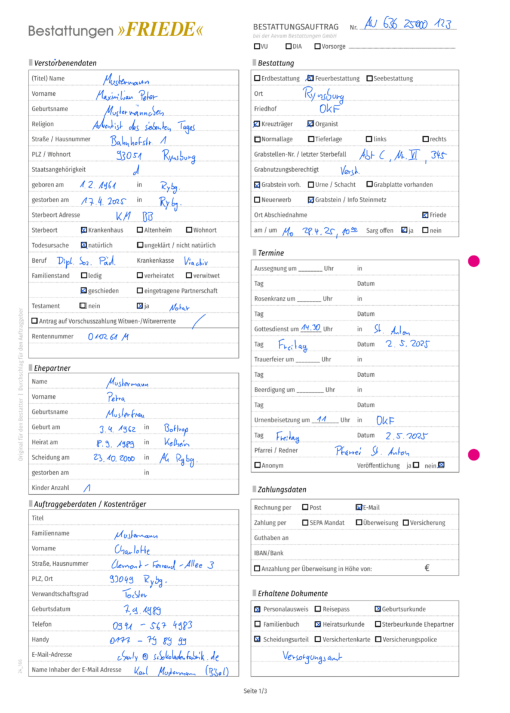

In [25]:
# Load the image
pages = convert_from_path("./testdaten/formular_ausgefüllt.pdf")
page = pages[0]

image = cv2.cvtColor(np.array(pages[0]), cv2.COLOR_RGB2BGR)
image = cv2.resize(image, (1654, 2338))

image_height = image.shape[0]
image_width = image.shape[1]
image_area = image_height * image_width

print(f"Height: {image_height}, Width: {image_width}, Area: {image_area}")

show(image)

# Document Scan

Transformed image would be too small. Returning original image.


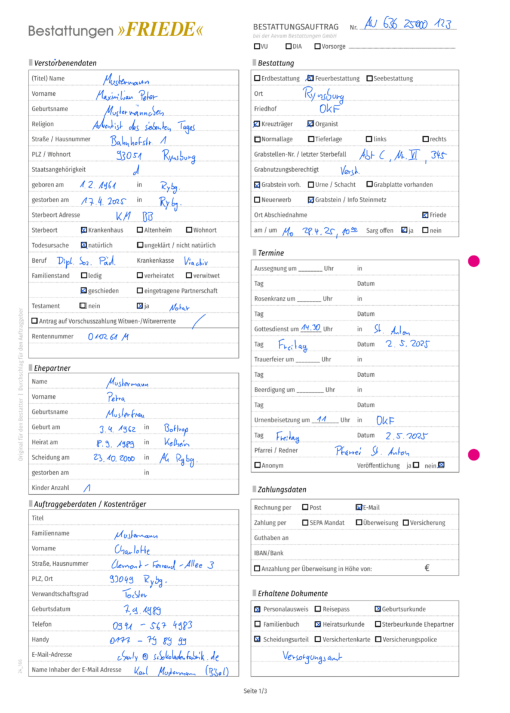

In [26]:
from src.scanning import scan_image

image = scan_image(image)
show(image)

# Layout Parsing

In diesem Abschnitt werden die BoundingRects der einzelnen auszufüllenden Zeilen bestimmt. Dafür werden folgende Schritte durchgeführt:

- Section Konturen bestimmen
- Field Konturen bestimmen

## Section Konturen bestimmen

Erkennung der 7 größten Konturen im Bild, nach Koordinaten sortieren und den Sections zuordnen

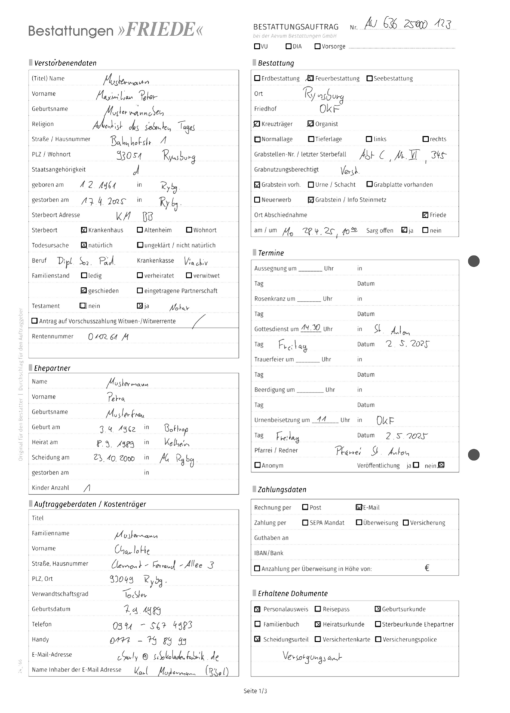

In [27]:
gray = cv2.medianBlur(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 3)
show(gray)

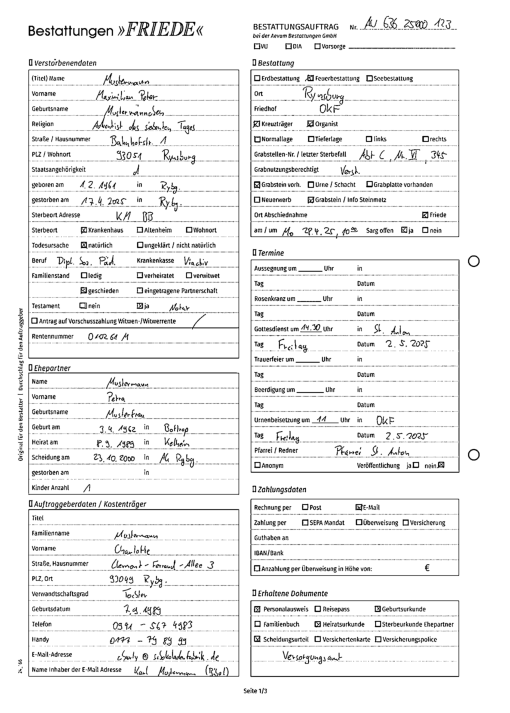

In [28]:
# Thresholding the image
img_bin = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 5)
show(img_bin)

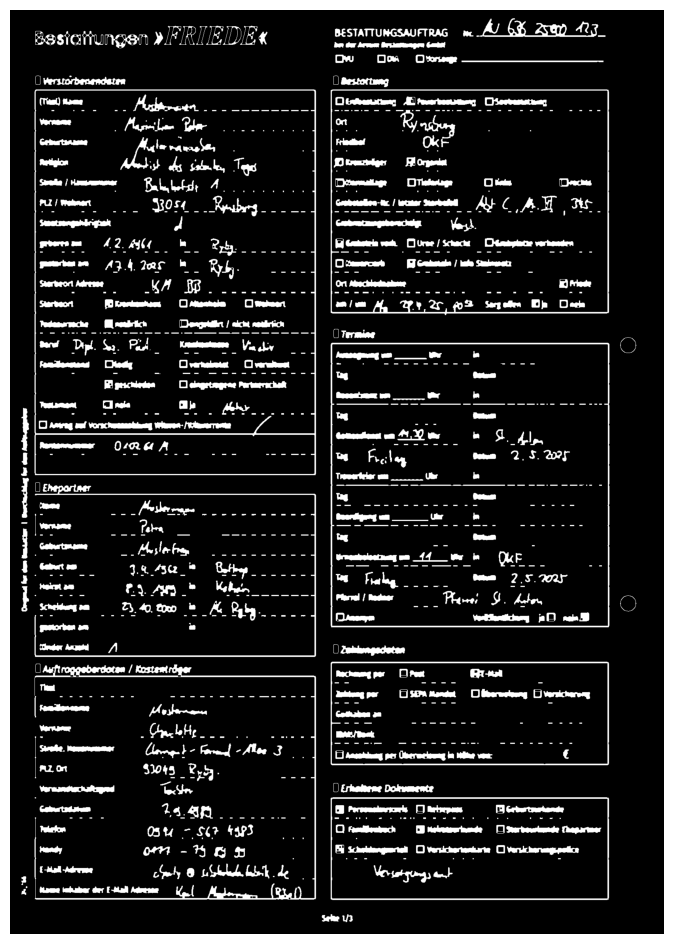

In [29]:
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Apply dilation to make edges thicker# Define a kernel
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))

# Dilation and Erosion
edges = cv2.dilate(edges, kernel, iterations=1)
edges = cv2.erode(edges, kernel, iterations=1)

show(edges, figsize=(21, 12))

In [30]:
# TODO: Eventuell corner detection noch ansehen

# Find contours in the binary image
contours, hierarchy = cv2.findContours(~img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw rectangles around each contour
img_sections = image.copy()
target_rois = []

rects = map(cv2.boundingRect, contours)
rects = [(x, y, w, h) for (x, y, w, h) in rects if not (w / image_width < 0.3 or w / image_width > 0.5)]
rects = sorted(rects, key=lambda x: x[0])

rects_left = sorted(rects[:3], key=lambda x: x[1])
rects_right = sorted(rects[3:], key=lambda x: x[1])

section_bounds = pd.DataFrame({
    "Verstorbenendaten": rects_left[0],
    "Ehepartner": rects_left[1],
    "Auftraggeberdaten": rects_left[2],
    "Bestattung": rects_right[0],
    "Termine": rects_right[1],
    "Zahlungsdaten": rects_right[2],
    "Erhaltene Dokumente": rects_right[3]
})
section_bounds

,Verstorbenendaten,Ehepartner,Auftraggeberdaten,Bestattung,Termine,Zahlungsdaten,Erhaltene Dokumente
0,62,62,62,810,811,810,810
1,201,1223,1684,201,842,1649,1992
2,710,710,710,703,703,703,703
3,975,413,565,570,719,260,258


## Field Konturen bestimmen

Anzahl der Zeilen (n) jeder Section durch Verwendung von `data/sections.csv` bestimmen, da jede Zeile die gleiche Höhe hat, kann die Section in n Zeilen mit gleicher Höhe aufgeteilt werden. Die Label für jede Zeile werden auch aus der CSV-Datei entnommen.

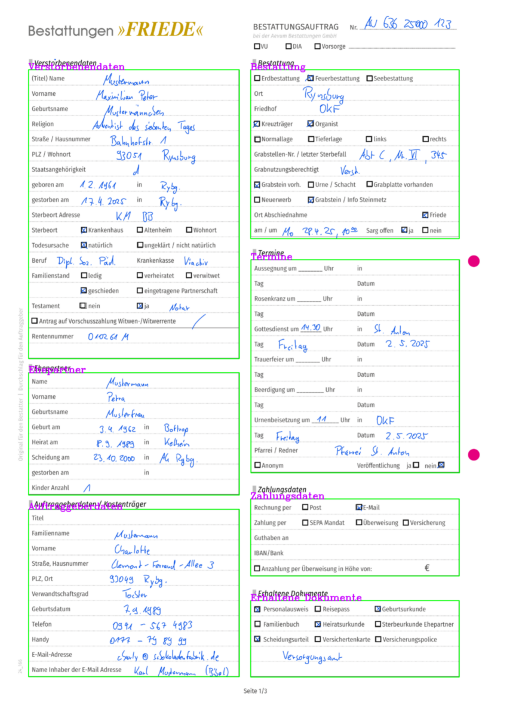

In [31]:
for key, (x, y, w, h) in section_bounds.items():
    cv2.rectangle(img_sections, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img_sections, key, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 200), 2)

show(img_sections)

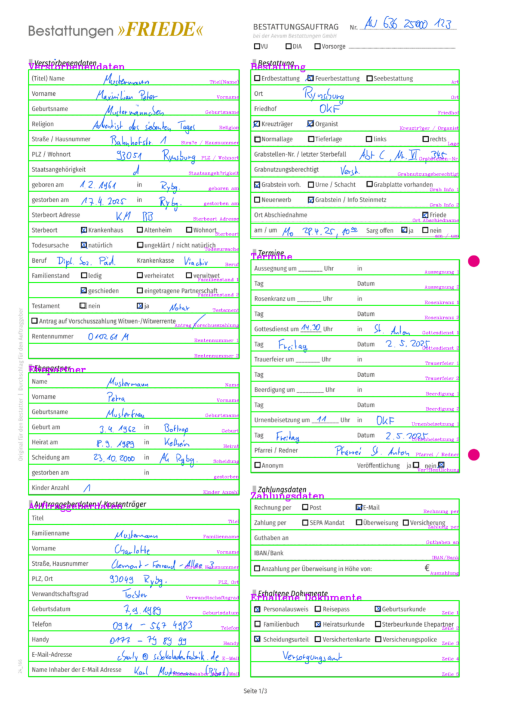

section                    field  \
section_index field_index                                                 
0             0              Verstorbenendaten              Titel(Name)   
              1              Verstorbenendaten                  Vorname   
              2              Verstorbenendaten              Geburtsname   
              3              Verstorbenendaten                 Religion   
              4              Verstorbenendaten      Straße / Hausnummer   
              5              Verstorbenendaten            PLZ / Wohnort   
              6              Verstorbenendaten      Staatsangehörigkeit   
              7              Verstorbenendaten               geboren am   
              8              Verstorbenendaten             gestorben am   
              9              Verstorbenendaten        Sterbeort Adresse   
              10             Verstorbenendaten                Sterbeort   
              11             Verstorbenendaten             Todesursache   
              12             Verstorbenendaten                    Beruf   
              13             Verstorbenendaten          Familienstand 1   
              14             Verstorbenendaten          Familienstand 2   
              15             Verstorbenendaten                Testament   
              16             Verstorbenendaten  Antrag Vorschusszahlung   
              17             Verstorbenendaten           Rentennummer 1   
              18             Verstorbenendaten           Rentennummer 2   
1             0                     Ehepartner                     Name   
              1                     Ehepartner                  Vorname   
              2                     Ehepartner              Geburtsname   
              3                     Ehepartner                   Geburt   
              4                     Ehepartner                   Heirat   
              5                     Ehepartner                Scheidung   
              6                     Ehepartner                gestorben   
              7                     Ehepartner            Kinder Anzahl   
2             0              Auftraggeberdaten                    Titel   
              1              Auftraggeberdaten             Familienname   
              2              Auftraggeberdaten                  Vorname   
              3              Auftraggeberdaten       Straße, Hausnummer   
              4              Auftraggeberdaten                 PLZ, Ort   
              5              Auftraggeberdaten      Verwandtschaftsgrad   
              6              Auftraggeberdaten             Geburtsdatum   
              7              Auftraggeberdaten                  Telefon   
              8              Auftraggeberdaten                    Handy   
              9              Auftraggeberdaten                   E-Mail   
              10             Auftraggeberdaten  Name Inhaber der E-Mail   
3             0                     Bestattung                      Art   
              1                     Bestattung                      Ort   
              2                     Bestattung                 Friedhof   
              3                     Bestattung   Kreuzträger / Organist   
              4                     Bestattung                     Lage   
              5                     Bestattung          Grabstellen-Nr.   
              6                     Bestattung   Grabnutzungsberechtigt   
              7                     Bestattung              Grab Info 1   
              8                     Bestattung              Grab Info 2   
              9                     Bestattung         Ort Abschiedname   
              10                    Bestattung                  am / um   
4             0                        Termine             Aussegnung 1   
              1                        Termine             Aussegnung 2   
              2                        Termine             Rosen

In [32]:
sections = pd.read_csv('data/sections.csv', index_col=["section_index", "field_index"])
img_fields = img_sections.copy()

def get_points(row):
    section_name = row["section"]
    field_index = row.name[1]
    (x, y, w, h) = section_bounds[section_name]

    parts = len(sections[sections.section == section_name])
    part_size = h / parts
    part_start_y = part_size * field_index

    # Returns top-left and bottom-right coordinates of a rectangle in relation to the section
    # point1: (x, part_start_y) - top left corner of the section
    # point2: (x + width, part_start_y + part_size) - bottom right corner of the section
    return [
        np.array([0, part_start_y]).astype(np.int32),
        np.array([w, part_start_y + part_size]).astype(np.int32)
    ]

sections["bounding_rect"] = sections.apply(get_points, axis=1)

for _, row in sections.iterrows():
    field_name = row["field"]
    section_name = row["section"]
    (x, y, w, h) = section_bounds[section_name]
    section_start = [x, y]

    [point1, point2] = row["bounding_rect"]

    cv2.rectangle(
        img_fields,
        point1 + section_start,
        point2 + section_start,
        (0, 255, 0),
        2)
    font = cv2.FONT_HERSHEY_COMPLEX
    font_size = 0.5
    font_thickness = 1
    ([text_width, _], text_height) = cv2.getTextSize(field_name, font, font_size, font_thickness)
    text_size = [text_width, text_height]
    cv2.putText(img_fields, field_name, np.array(point2 - text_size + section_start).astype(np.int32), font, font_size, (255, 0, 200), font_thickness)

show(img_fields)
sections

# Crop Sections
In diesem Abschnitt werden die einzelnen Formularzellen (z.B. Verstorbenendaten) zugeschnitten zur besseren Erkennung der handschriftlichen Texte. Die zugeschnittenen Texte werden zusätzlich im Ordner output/cropped gespeichert.

In [33]:
def cropToSection(section: str):
    x, y, w, h = section_bounds[section]

    result_img = image.copy()
    cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 0, 255), 3)

    # Crop and display the Verstorbenendaten section
    cropped_section = result_img[y:y+h, x:x+w]


    # Save the cropped section to a file
    output_path = f'output/cropped/cropped_{section}_section.jpg'
    cv2.imwrite(output_path, cv2.cvtColor(cropped_section, cv2.COLOR_RGB2BGR))
    print(f"Saved cropped section to {output_path}")
    show(cropped_section, figsize=(3, 3), title=f'Cropped {section} section')

    return cropped_section

Saved cropped section to output/cropped/cropped_Verstorbenendaten_section.jpg


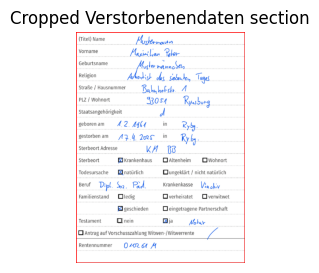

Saved cropped section to output/cropped/cropped_Ehepartner_section.jpg


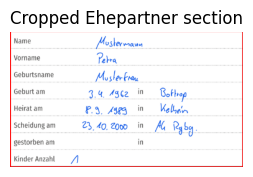

Saved cropped section to output/cropped/cropped_Auftraggeberdaten_section.jpg


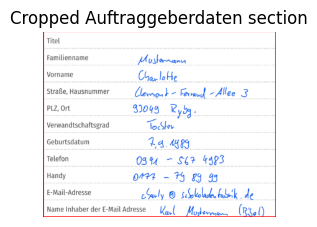

Saved cropped section to output/cropped/cropped_Bestattung_section.jpg


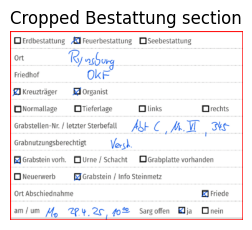

Saved cropped section to output/cropped/cropped_Termine_section.jpg


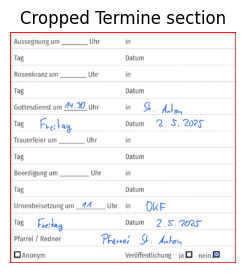

Saved cropped section to output/cropped/cropped_Zahlungsdaten_section.jpg


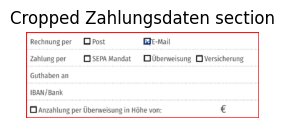

Saved cropped section to output/cropped/cropped_Erhaltene Dokumente_section.jpg


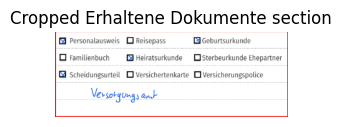

In [34]:
# Croppe Verstorbenendaten section and save it to a file
cropped_sections = []
for i, row in enumerate(section_bounds):
    cropped_sections.append((row, cropToSection(row)))

# Text Detection
## Remove/Keep Blue Color Pixels
In diesem Schritt wird der handschriftliche Text durch eine gezielte Farbanalyse extrahiert. Dabei wird angenommen, dass blaue Schrift handschriftlich ist, während schwarze Schrift dem gedruckten Text entspricht. Jeder zuvor zugeschnittene Abschnitt wird auf den Farbton „Blau“ hin gefiltert, sodass ausschließlich der handschriftliche Text übrig bleibt. Die so gewonnenen Ergebnisse werden anschließend im Verzeichnis output/handwritten gespeichert.

In [35]:
# Remove font that has been identified as black from the image
# blue font should represent the handwritten text

def only_color_between(img_bgr, lower_bound, upper_bound):
    # Convert to HSV color space
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # Create mask for blue pixels
    blue_mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Create result image with white background
    result = np.full_like(img_bgr, 255)

    # Copy only blue pixels to result image
    result = cv2.bitwise_and(img_bgr, img_bgr, mask=blue_mask)

    # Set non-blue pixels to white
    result[blue_mask == 0] = [255, 255, 255]
    return result

def remove_color_between(img_bgr, lower_bound, upper_bound):
    # Convert to HSV color space
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # Create mask for blue pixels
    blue_mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Invert the mask: now non-blue areas are 255, blue areas are 0
    non_blue_mask = cv2.bitwise_not(blue_mask)

    # Create result image with white background
    result = np.full_like(img_bgr, 255)

    # Copy only blue pixels to result image
    result = cv2.bitwise_and(img_bgr, img_bgr, mask=non_blue_mask)

    # Set non-blue pixels to white
    result[non_blue_mask == 0] = [255, 255, 255]
    return result


def only_blue_pixels(image_bgr):
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])

    return only_color_between(image_bgr, lower_blue, upper_blue)

def remove_blue_pixels(image_bgr):
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])

    return remove_color_between(image_bgr, lower_blue, upper_blue)

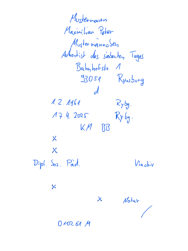

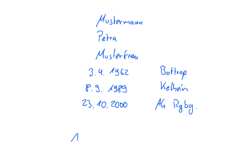

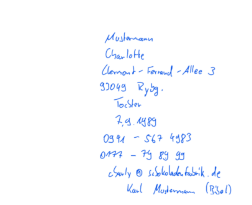

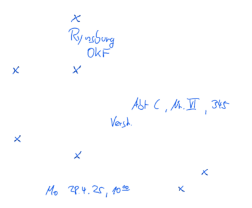

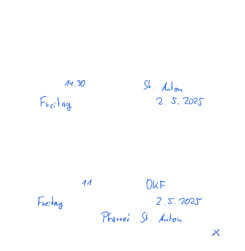

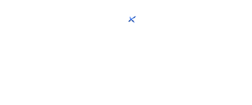

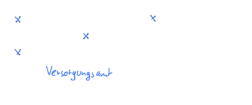

In [36]:
imgs_handwritten = []

for i, (section, img) in enumerate(cropped_sections):
    img_handwritten = only_blue_pixels(img)
    imgs_handwritten.append((section, img_handwritten))

    show(img_handwritten, figsize=(3, 3))
    cv2.imwrite(f'output/handwritten/img_handwritten_{section}.jpg', img_handwritten)

## Detect handwritten text bounding rects
In diesem Schritt wird mit Hilfe von PaddleOCR der handschriftliche Text erkannt. Zusätzlich werden rechteckige Begrenzungsrahmen (Bounding Rectangles) um die erkannten Textbereiche gezeichnet. Zur weiteren Bearbeitung werden außerdem die Mittelpunkte der handschriftlichen Boxen berechnet.

In [37]:
from paddleocr import TextDetection

model = TextDetection(model_name="PP-OCRv5_server_det", enable_mkldnn=False)

def detect_boxes(img_path, filename):
    result = model.predict(img_path)
    for row in result:
        row.save_to_img(f"output/detected/{filename}.jpg")
        
        return row

Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /Users/mdo/.paddlex/official_models.


In [38]:
hw_coordinates = {}
hw_centers = {}

# detect handwritten text with PaddleOCR
for i, (section, img) in enumerate(imgs_handwritten):
    img_path = f"output/handwritten/img_handwritten_{section}.jpg"
    print(f"Detect handwriting in section {section}...")
    # handwritten_boxes = detect_boxes(img_path, f"detected_hw_boxes_{section}")
    result = detect_boxes(img_path, f"detected_hw_boxes_{section}")

    boxes = result["dt_polys"]
    y_middles = []
    for point in boxes:
        y_coords = [p[1] for p in point]
        min_y = min(y_coords)
        max_y = max(y_coords)
        y_middle = (min_y + max_y) / 2

        y_middles.append(y_middle)

    hw_centers[section] = y_middles
    hw_coordinates[section] = boxes

Detect handwriting in section Verstorbenendaten...
Detect handwriting in section Ehepartner...
Detect handwriting in section Auftraggeberdaten...
Detect handwriting in section Bestattung...
Detect handwriting in section Termine...
Detect handwriting in section Zahlungsdaten...
Detect handwriting in section Erhaltene Dokumente...


# Assign handwritten bounding rects to label bounding rects
Anschließend werden die erkannten Begrenzungsboxen der handschriftlichen Texte den zuvor identifizierten Label-Boxen zugeordnet. Diese Zuordnung erfolgt durch eine Überprüfung, ob der Mittelpunkt der jeweiligen Handschrift-Box innerhalb der Grenzen einer Label-Box liegt.

In [39]:
# assign handwritten boxes to label rows
def assign_boxes_to_rows(hw_center, hw_coords, label_rows):
    assignments = []

    # Calculate center points for each handwritten box
    for j, y in enumerate(hw_center):
        # Check which row contains this center point
        for i, row in enumerate(label_rows):
            left_top_pt = row[0]
            bottom_right_pt = row[1]

            if left_top_pt[1] <= y <= bottom_right_pt[1]:
                assignments.append((i, hw_coords[j]))

    return assignments

label_hw_assigments = {}

# Create a dictionary mapping section indices to section names
section_map = {idx: name for idx, name in enumerate(sections["section"].unique())}

for idx, name in section_map.items():
    hw_section_center = hw_centers[name]
    hw_section_coords = hw_coordinates[name]

    section_label_boxes = sections["bounding_rect"][idx]
    label_hw_assigments[name] = assign_boxes_to_rows(hw_section_center, hw_section_coords, section_label_boxes)

In [40]:
# save assignments to sections dataframe
def get_hw_points(row):
    field_index = row.name[1]
    section_name = row["section"]

    hw_rects = []

    section_assignments = label_hw_assigments[section_name]

    for item in section_assignments:
        if item[0] == field_index:
            hw_rects.append(item[1])

    return hw_rects

sections["handwritten_bounding_rect"] = sections.apply(get_hw_points, axis=1)
sections

section                    field  \
section_index field_index                                                 
0             0              Verstorbenendaten              Titel(Name)   
              1              Verstorbenendaten                  Vorname   
              2              Verstorbenendaten              Geburtsname   
              3              Verstorbenendaten                 Religion   
              4              Verstorbenendaten      Straße / Hausnummer   
              5              Verstorbenendaten            PLZ / Wohnort   
              6              Verstorbenendaten      Staatsangehörigkeit   
              7              Verstorbenendaten               geboren am   
              8              Verstorbenendaten             gestorben am   
              9              Verstorbenendaten        Sterbeort Adresse   
              10             Verstorbenendaten                Sterbeort   
              11             Verstorbenendaten             Todesursache   
              12             Verstorbenendaten                    Beruf   
              13             Verstorbenendaten          Familienstand 1   
              14             Verstorbenendaten          Familienstand 2   
              15             Verstorbenendaten                Testament   
              16             Verstorbenendaten  Antrag Vorschusszahlung   
              17             Verstorbenendaten           Rentennummer 1   
              18             Verstorbenendaten           Rentennummer 2   
1             0                     Ehepartner                     Name   
              1                     Ehepartner                  Vorname   
              2                     Ehepartner              Geburtsname   
              3                     Ehepartner                   Geburt   
              4                     Ehepartner                   Heirat   
              5                     Ehepartner                Scheidung   
              6                     Ehepartner                gestorben   
              7                     Ehepartner            Kinder Anzahl   
2             0              Auftraggeberdaten                    Titel   
              1              Auftraggeberdaten             Familienname   
              2              Auftraggeberdaten                  Vorname   
              3              Auftraggeberdaten       Straße, Hausnummer   
              4              Auftraggeberdaten                 PLZ, Ort   
              5              Auftraggeberdaten      Verwandtschaftsgrad   
              6              Auftraggeberdaten             Geburtsdatum   
              7              Auftraggeberdaten                  Telefon   
              8              Auftraggeberdaten                    Handy   
              9              Auftraggeberdaten                   E-Mail   
              10             Auftraggeberdaten  Name Inhaber der E-Mail   
3             0                     Bestattung                      Art   
              1                     Bestattung                      Ort   
              2                     Bestattung                 Friedhof   
              3                     Bestattung   Kreuzträger / Organist   
              4                     Bestattung                     Lage   
              5                     Bestattung          Grabstellen-Nr.   
              6                     Bestattung   Grabnutzungsberechtigt   
              7                     Bestattung              Grab Info 1   
              8                     Bestattung              Grab Info 2   
              9                     Bestattung         Ort Abschiedname   
              10                    Bestattung                  am / um   
4             0                        Termine             Aussegnung 1   
              1                        Termine             Aussegnung 2   
              2                        Termine             Rosen

# Text Recognition
In diesem Abschnitt erfolgt die Erkennung der handschriftlichen Wörter oder Wortgruppen.\
Das Modell und der benötigte Przessor werden erst initialisiert.
Dann werden die in den vorherigen Abschnitten ermittelten Textschnippsel genutzt und mit dem Transformer-basierten OCR-Modell "TrOCR" (https://doi.org/10.48550/arXiv.2109.10282) erkannt.\
Die erkannten Wörter werden anschließend für jede Zeile an die Datenstruktur angehängt, sobald die Erkennung abgeschlossen ist.

In [41]:
!pip install --upgrade tokenizers
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained('fhswf/TrOCR_german_handwritten')
model = VisionEncoderDecoderModel.from_pretrained('fhswf/TrOCR_german_handwritten')

  Using cached tokenizers-0.21.1-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.8 kB)
Using cached tokenizers-0.21.1-cp39-abi3-macosx_11_0_arm64.whl (2.7 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1


Schrifterkennung für Abschnitt Verstorbenendaten läuft...


/Users/mdo/miniforge3/envs/paddle/lib/python3.12/site-packages/transformers/generation/utils.py:1730: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


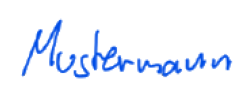

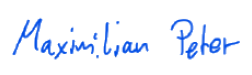

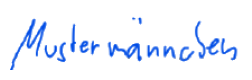

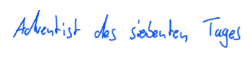

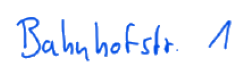

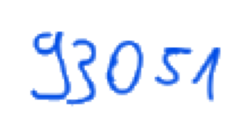

Schrifterkennung für Abschnitt Ehepartner läuft...
Schrifterkennung für Abschnitt Auftraggeberdaten läuft...
Schrifterkennung für Abschnitt Bestattung läuft...
Schrifterkennung für Abschnitt Termine läuft...
Schrifterkennung für Abschnitt Zahlungsdaten läuft...
Schrifterkennung für Abschnitt Erhaltene Dokumente läuft...


section                    field  \
section_index field_index                                                 
0             0              Verstorbenendaten              Titel(Name)   
              1              Verstorbenendaten                  Vorname   
              2              Verstorbenendaten              Geburtsname   
              3              Verstorbenendaten                 Religion   
              4              Verstorbenendaten      Straße / Hausnummer   
              5              Verstorbenendaten            PLZ / Wohnort   
              6              Verstorbenendaten      Staatsangehörigkeit   
              7              Verstorbenendaten               geboren am   
              8              Verstorbenendaten             gestorben am   
              9              Verstorbenendaten        Sterbeort Adresse   
              10             Verstorbenendaten                Sterbeort   
              11             Verstorbenendaten             Todesursache   
              12             Verstorbenendaten                    Beruf   
              13             Verstorbenendaten          Familienstand 1   
              14             Verstorbenendaten          Familienstand 2   
              15             Verstorbenendaten                Testament   
              16             Verstorbenendaten  Antrag Vorschusszahlung   
              17             Verstorbenendaten           Rentennummer 1   
              18             Verstorbenendaten           Rentennummer 2   
1             0                     Ehepartner                     Name   
              1                     Ehepartner                  Vorname   
              2                     Ehepartner              Geburtsname   
              3                     Ehepartner                   Geburt   
              4                     Ehepartner                   Heirat   
              5                     Ehepartner                Scheidung   
              6                     Ehepartner                gestorben   
              7                     Ehepartner            Kinder Anzahl   
2             0              Auftraggeberdaten                    Titel   
              1              Auftraggeberdaten             Familienname   
              2              Auftraggeberdaten                  Vorname   
              3              Auftraggeberdaten       Straße, Hausnummer   
              4              Auftraggeberdaten                 PLZ, Ort   
              5              Auftraggeberdaten      Verwandtschaftsgrad   
              6              Auftraggeberdaten             Geburtsdatum   
              7              Auftraggeberdaten                  Telefon   
              8              Auftraggeberdaten                    Handy   
              9              Auftraggeberdaten                   E-Mail   
              10             Auftraggeberdaten  Name Inhaber der E-Mail   
3             0                     Bestattung                      Art   
              1                     Bestattung                      Ort   
              2                     Bestattung                 Friedhof   
              3                     Bestattung   Kreuzträger / Organist   
              4                     Bestattung                     Lage   
              5                     Bestattung          Grabstellen-Nr.   
              6                     Bestattung   Grabnutzungsberechtigt   
              7                     Bestattung              Grab Info 1   
              8                     Bestattung              Grab Info 2   
              9                     Bestattung         Ort Abschiedname   
              10                    Bestattung                  am / um   
4             0                        Termine             Aussegnung 1   
              1                        Termine             Aussegnung 2   
              2                        Termine             Rosen

In [42]:
def recognizeTROCR(image):
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text


section_name = sections['section']
field_name = sections["field"]
hw = sections['handwritten_bounding_rect']
recognized_text = []
stopper = 0 # Zum testen für schwächere Rechner oder zum Demonstrieren. Unterbricht die Auswertung wenn es einen bestimmten Wert erreicht.
stopper_stop = -1 # wenn = -1, dann kein stoppen

for g_index, _ in enumerate(sections.groupby('section')):
    img = imgs_handwritten[g_index][1]

    print("Schrifterkennung für Abschnitt "+section_name.get(g_index)[0]+" läuft...")
    for i, row in enumerate(hw.get(g_index)):
        if(stopper_stop > -1 and stopper >= stopper_stop):
            break

        if len(row) > 0:
            p1 = row[0][0]
            p2 = row[0][1]
            p3 = row[0][2]
            p4 = row[0][3]

            top_left_x = min([p1[0],p2[0],p3[0],p4[0]])
            top_left_y = min([p1[1],p2[1],p3[1],p4[1]])
            bot_right_x = max([p1[0],p2[0],p3[0],p4[0]])
            bot_right_y = max([p1[1],p2[1],p3[1],p4[1]])

            crop = img[top_left_y:bot_right_y, top_left_x:bot_right_x]

            text = recognizeTROCR(crop)
            recognized_text.append(text)

            if (stopper <= 5):
                show(crop, figsize=(3,3)) # demonstrativ
        else:
            text = "handwritten_bounding_rect ist leer. Nichts erkannt"
            recognized_text.append(text)

        stopper +=1

        #print(text) # demonstrativ

    # Auffüllen des arrays damit es trotz Unvollständigkeit durch den stopper, an die Datenstruktur angehangen werden kann
    if(stopper_stop > -1):
        while len(recognized_text) < len(sections):
            recognized_text.append("Platzhalter")

sections["recognized_text"] = recognized_text
sections

# Checkboxes

In diesem Abschnitt werden die Checkboxen der einzelnen Zeilen erkannt und erkannt ob diese angekreuzt sind oder nicht. Dies passiert in 2 Schritten:

## 1. Schritt - Positionen der Checkboxen bestimmen

Hierfür wurde die Datei `data/choices.csv` angelegt in denen Labels für die einzelnen Checkboxen der jeweiligen Zeilen angegeben wurden. Die Reihenfolge dafür ist identisch zu der Reihenfolge in der diese im Formular auch auftauchen.

Zur Bestimmung der Positionen der Checkboxen wird für jede Zeile einzeln die Funktion `findContours` von OpenCV benutzt. Dabei werden die n größten Konturen der Zeile verwendet, wobei n die Anzahl der Checkboxen in der aktuellen Zeile ist.

## 2. Schritt - Herausfinden ob Checkbox angekreuzt

Um herauszufinden ob die Checkbox angekreuzt wurde, werden die blauen Pixel in dem Bereich der Checkbox gezählt. Wenn dieser Wert einen bestimmten Wert überschreitet wird die Checkbox als angekreuzt erkannt.

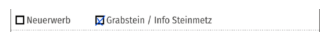

Neuerwerb


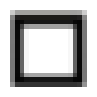

Grabstein / Info Steinmetz


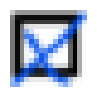

[False, True]

In [43]:
row = sections.loc[0,10]

def get_checkbox_images(row, field_labels):
    count = len(field_labels)
    (x, y, w, h) = section_bounds[row["section"]]
    [min, max] = row["bounding_rect"]

    # Removing blue pixels would leave us open contours therefore contour detection would not work correctly
    # row_img = remove_blue_pixels(image[y+min[1]:y+max[1], x+min[0]:x+max[0]].copy())
    row_img = image[y+min[1]:y+max[1], x+min[0]:x+max[0]].copy()
    show(row_img, figsize=(4, 1))

    row_blur = cv2.pyrMeanShiftFiltering(row_img, 16, 64)
    #show(row_blur)
    row_gray = cv2.cvtColor(row_blur, cv2.COLOR_BGR2GRAY)
    #show(row_gray)
    row_bin = cv2.threshold(row_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    #show(row_bin)

    row_cnts, row_hierarchy = cv2.findContours(row_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Keeping only the largest detected contour
    row_page = sorted(row_cnts, key=cv2.contourArea, reverse=True)[:count]
    row_rects = sorted([*map(cv2.boundingRect, row_page)], key=lambda x: x[0])
    row_checkbox_images = [cv2.resize(row_img[ry:ry+rh, rx:rx+rw].copy(), (16,16)) for (rx, ry, rw, rh) in row_rects]
    return row_checkbox_images

def get_checkbox_values(row_checkbox_images, field_labels):
    for [label, check] in zip(field_labels, row_checkbox_images):
        print(label)
        show(check, figsize=(1, 1))

    row_blue = [only_blue_pixels(row_rect) for row_rect in row_checkbox_images]
    row_check_gray = [255 - cv2.cvtColor(row_rect, cv2.COLOR_BGR2GRAY) for row_rect in row_blue]

    row_is_checked = [np.sum(rect) > 500 for rect in row_check_gray]

    return row_is_checked

def get_row_choices(row, field_labels):
    # step 1: get images of checkboxes for line
    row_checkbox_images = get_checkbox_images(row, field_labels)

    # step 2: find out if checkboxes are checked or not
    return get_checkbox_values(row_checkbox_images, field_labels)

get_row_choices(sections.loc[3,8], ["Neuerwerb", "Grabstein / Info Steinmetz"])

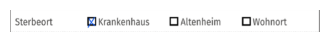

Krankenhaus


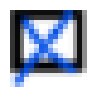

Altenheim


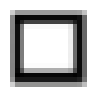

Wohnort


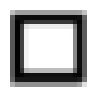

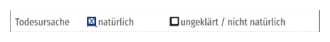

natürlich


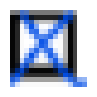

ungeklärt


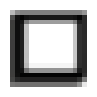

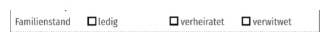

ledig


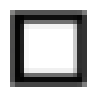

verheiratet


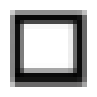

verwitwet


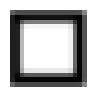

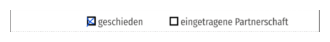

geschieden


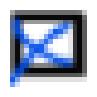

eingetragene Partnerschaft


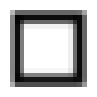

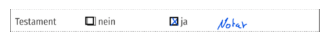

nein


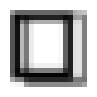

ja


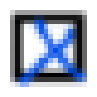

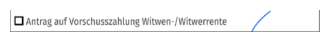

Antrag


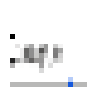

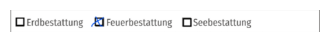

Erdbestattung


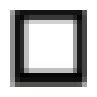

Feuerbestattung


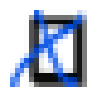

Seebestattung


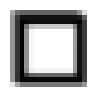

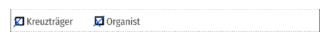

Kreuzträger


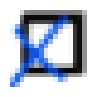

Organist


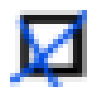

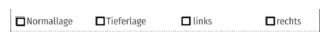

Normallage


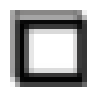

Tieferlage


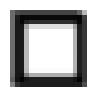

links


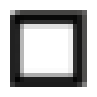

rechts


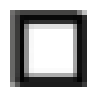

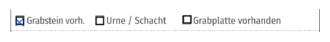

Grabstein vorh.


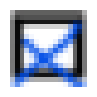

Urne / Schacht


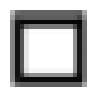

Grabplatte vorhanden


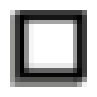

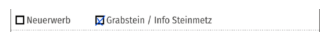

Neuerwerb


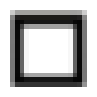

Grabstein/ Info Steinmetz


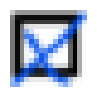

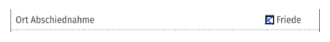

Friede


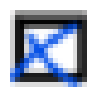

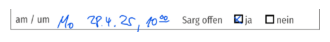

ja


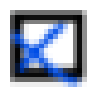

nein


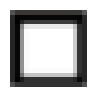

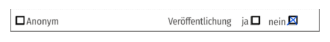

Anonym


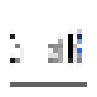

ja


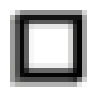

nein


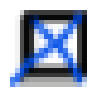

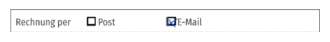

Post


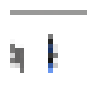

E-mail


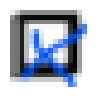

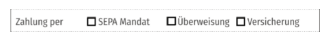

SEPA Mandat


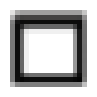

Überweisung


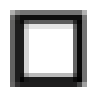

Versicherung


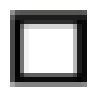

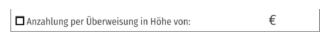

Anzahlung


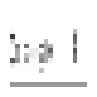

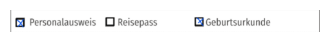

Personalausweis


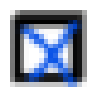

Reisepass


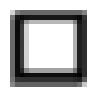

Geburtsurkunde


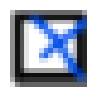

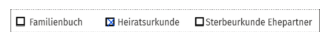

Familienbuch


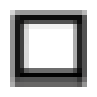

Heiratsurkunde


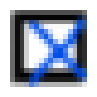

Sterbeurkunde Ehepartner


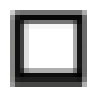

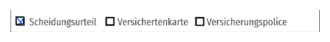

Scheidungsurteil


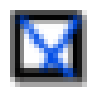

Versichertenkarte


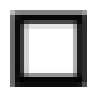

Versicherungspolice


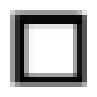

section                    field  \
section_index field_index                                                 
0             0              Verstorbenendaten              Titel(Name)   
              1              Verstorbenendaten                  Vorname   
              2              Verstorbenendaten              Geburtsname   
              3              Verstorbenendaten                 Religion   
              4              Verstorbenendaten      Straße / Hausnummer   
              5              Verstorbenendaten            PLZ / Wohnort   
              6              Verstorbenendaten      Staatsangehörigkeit   
              7              Verstorbenendaten               geboren am   
              8              Verstorbenendaten             gestorben am   
              9              Verstorbenendaten        Sterbeort Adresse   
              10             Verstorbenendaten                Sterbeort   
              11             Verstorbenendaten             Todesursache   
              12             Verstorbenendaten                    Beruf   
              13             Verstorbenendaten          Familienstand 1   
              14             Verstorbenendaten          Familienstand 2   
              15             Verstorbenendaten                Testament   
              16             Verstorbenendaten  Antrag Vorschusszahlung   
              17             Verstorbenendaten           Rentennummer 1   
              18             Verstorbenendaten           Rentennummer 2   
1             0                     Ehepartner                     Name   
              1                     Ehepartner                  Vorname   
              2                     Ehepartner              Geburtsname   
              3                     Ehepartner                   Geburt   
              4                     Ehepartner                   Heirat   
              5                     Ehepartner                Scheidung   
              6                     Ehepartner                gestorben   
              7                     Ehepartner            Kinder Anzahl   
2             0              Auftraggeberdaten                    Titel   
              1              Auftraggeberdaten             Familienname   
              2              Auftraggeberdaten                  Vorname   
              3              Auftraggeberdaten       Straße, Hausnummer   
              4              Auftraggeberdaten                 PLZ, Ort   
              5              Auftraggeberdaten      Verwandtschaftsgrad   
              6              Auftraggeberdaten             Geburtsdatum   
              7              Auftraggeberdaten                  Telefon   
              8              Auftraggeberdaten                    Handy   
              9              Auftraggeberdaten                   E-Mail   
              10             Auftraggeberdaten  Name Inhaber der E-Mail   
3             0                     Bestattung                      Art   
              1                     Bestattung                      Ort   
              2                     Bestattung                 Friedhof   
              3                     Bestattung   Kreuzträger / Organist   
              4                     Bestattung                     Lage   
              5                     Bestattung          Grabstellen-Nr.   
              6                     Bestattung   Grabnutzungsberechtigt   
              7                     Bestattung              Grab Info 1   
              8                     Bestattung              Grab Info 2   
              9                     Bestattung         Ort Abschiedname   
              10                    Bestattung                  am / um   
4             0                        Termine             Aussegnung 1   
              1                        Termine             Aussegnung 2   
              2                        Termine             Rosen

In [44]:
choices = pd.read_csv("data/choices.csv")

test = pd.DataFrame(choices.groupby(["section_index", "field_index"])['label'].apply(list))

test["choices"] = test.apply(lambda x: get_row_choices(sections.loc[x.name], x.label), axis=1)

sections["choice_labels"] = test["label"]
sections["choices"] = test["choices"]
sections
